<img src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500, height=450>
<h3 style="text-align: center;"><b>Физтех-Школа Прикладной математики и информатики (ФПМИ) МФТИ</b></h3>

Student: Oleg Navolotsky / Олег Наволоцкий  
Stepik: https://stepik.org/users/2403189  
Telegram: [@mehwhatever0](https://t.me/mehwhatever0)  

**Note**: reproducibility depends on [different things](https://pytorch.org/docs/stable/notes/randomness.html):
>Completely reproducible results are not guaranteed across PyTorch releases, individual commits, or different platforms. Furthermore, results may not be reproducible between CPU and GPU executions, even when using identical seeds.

Some used software versions:
- PyTorch 1.8.1
- torchtext 0.9.1
- NumPy 1.19.2
- scikit-learn 0.24.1
- nltk 3.5
- pandas 1.2.3
- matplotlib 3.3.4
- rnnmorph 0.4.0
- Python 3.8.8 (default, Feb 24 2021, 15:54:32) \[MSC v.1928 64 bit (AMD64)] :: Anaconda, Inc. on win32
- NVIDIA Driver 461.33
- NVIDIA CUDA 11.2
- Windows 10 Pro 1909, build 18363.535


Hardware:
- i5 2500 8 gb
- GTX 1060 6 gb

In [1]:
import warnings

warnings.filterwarnings("ignore", module="ipykernel", category=DeprecationWarning)

In [2]:
import os
import random

import numpy as np
import torch


SEED = 0


def enable_reproducibility(
        seed=SEED, raise_if_no_deterministic=True,
        cudnn_deterministic=True, disable_cudnn_benchmarking=True):
    # https://pytorch.org/docs/stable/notes/randomness.html#avoiding-nondeterministic-algorithms
    torch.use_deterministic_algorithms(raise_if_no_deterministic)

    # https://docs.nvidia.com/cuda/cublas/index.html#cublasApi_reproducibility
    os.environ['CUBLAS_WORKSPACE_CONFIG'] = ":4096:8"
    
    torch.backends.cudnn.benchmark = not disable_cudnn_benchmarking
    torch.backends.cudnn.deterministic = cudnn_deterministic

    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

In [3]:
enable_reproducibility()

In [4]:
import shelve

import pandas as pd

experiments_results_data = shelve.open("experiments_results_data")

def add_experiment_results(experiment, test_accuracy, training_time, testing_time):
    experiments_results_data[experiment] = {
        var.replace('_', ' '): val for var, val in locals().items() if var != 'experiment'}

def clear_experiments_results():
    experiments_results_data.clear()

def get_experiments_results_table():
    df = pd.DataFrame.from_dict(experiments_results_data, orient='index')
    df.index.name = 'experiment'
    return df


@torch.no_grad()
def predict_tags_by_nn(model, sentence, device, batch_first=True, lower=True):
    model.eval()
    if lower:
        sentence = [word.lower() for word in sentence]
    example = torch.LongTensor(
        [words_vocab.stoi[word] for word in sentence]
    ).unsqueeze(0 if batch_first else 1).to(device)
    output = model(example)
    pred = output.argmax(dim=-1).squeeze(0 if batch_first else 1).cpu().numpy()
    tags = [tags_vocab.itos[elem] for elem in pred]
    return tags

def predict_tags_by_markov(model, sentence, lower=True):
    if lower:
        sentence = [word.lower() for word in sentence]
    return model.predict([sentence])[0]

def predict_tags(model, sentence, device=None, batch_first=True, lower=True):
    if isinstance(sentence, str):
        raise ValueError("sentence must be tokenized")
    if isinstance(sentence[0], str):
        words = sentence
    else:
        words, _ = sentence
    if isinstance(model, torch.nn.Module):
        if device is None:
            raise ValueError("device must be given when model is instance of torch.nn.Module")
        tags = predict_tags_by_nn(model, words, device, batch_first, lower)
    else:
        tags = predict_tags_by_markov(model, words, lower)
    return tags
    
test_sentence = "He walked along the path in his favourite park in England and thought about favorite book he bought in the US.".split()
test_sentence_predictions_results = shelve.open("test_sentence_predictions_results")

def add_prediction_on_test_sentence(experiment, model, device=None, batch_first=True, lower=True):
    test_sentence_predictions_results[experiment] = predict_tags(model, test_sentence, device, batch_first, lower)

def clear_predictions_results():
    test_sentence_predictions_results.clear()

def get_predictions_results_table():
    df = pd.DataFrame.from_dict(test_sentence_predictions_results, orient='index', columns=test_sentence)
    df.index.name = 'experiment'
    return df

In [5]:
def try_to_clear_cuda_memory(variables_names=("model", "optimizer")):
    for name in (variables_names):
        try:
            del globals()[name]
        except KeyError:
            pass
    torch.cuda.empty_cache()

---

### Задача определения частей речи, Part-Of-Speech Tagger (POS)

Мы будем решать задачу определения частей речи (POS-теггинга) с помощью скрытой марковской модели (HMM).

Вам в помощь http://www.nltk.org/book/

Загрузим brown корпус

In [6]:
import nltk
from nltk.corpus import brown

nltk.download('brown')

[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\user0\AppData\Roaming\nltk_data...
[nltk_data]   Package brown is already up-to-date!


True

Существует множество наборов грамматических тегов, или тегсетов, например:
* НКРЯ
* Mystem
* UPenn
* OpenCorpora (его использует pymorphy2)
* Universal Dependencies

<b>Существует не одна система тегирования, поэтому будьте внимательны, когда прогнозируете тег слов в тексте и вычисляете качество прогноза. Можете получить несправедливо низкое качество вашего решения.

На данный момент стандартом является **Universal Dependencies**. Подробнее про проект можно почитать [вот тут](http://universaldependencies.org/), а про теги — [вот тут](http://universaldependencies.org/u/pos/)

In [7]:
nltk.download('universal_tagset')

[nltk_data] Downloading package universal_tagset to
[nltk_data]     C:\Users\user0\AppData\Roaming\nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


True

<img src="https://4.bp.blogspot.com/-IcFli2wljs0/WrVCw3umY_I/AAAAAAAACYM/UJ_neoUAs3wF95dj2Ouf3BzxXzB_b2TbQCLcBGAs/s1600/postags.png">


Мы имеем массив предложений пар (слово-тег)

In [8]:
brown_tagged_sents = brown.tagged_sents(tagset="universal")
brown_tagged_sents

[[('The', 'DET'), ('Fulton', 'NOUN'), ('County', 'NOUN'), ('Grand', 'ADJ'), ('Jury', 'NOUN'), ('said', 'VERB'), ('Friday', 'NOUN'), ('an', 'DET'), ('investigation', 'NOUN'), ('of', 'ADP'), ("Atlanta's", 'NOUN'), ('recent', 'ADJ'), ('primary', 'NOUN'), ('election', 'NOUN'), ('produced', 'VERB'), ('``', '.'), ('no', 'DET'), ('evidence', 'NOUN'), ("''", '.'), ('that', 'ADP'), ('any', 'DET'), ('irregularities', 'NOUN'), ('took', 'VERB'), ('place', 'NOUN'), ('.', '.')], [('The', 'DET'), ('jury', 'NOUN'), ('further', 'ADV'), ('said', 'VERB'), ('in', 'ADP'), ('term-end', 'NOUN'), ('presentments', 'NOUN'), ('that', 'ADP'), ('the', 'DET'), ('City', 'NOUN'), ('Executive', 'ADJ'), ('Committee', 'NOUN'), (',', '.'), ('which', 'DET'), ('had', 'VERB'), ('over-all', 'ADJ'), ('charge', 'NOUN'), ('of', 'ADP'), ('the', 'DET'), ('election', 'NOUN'), (',', '.'), ('``', '.'), ('deserves', 'VERB'), ('the', 'DET'), ('praise', 'NOUN'), ('and', 'CONJ'), ('thanks', 'NOUN'), ('of', 'ADP'), ('the', 'DET'), ('City

Первое предложение

In [9]:
brown_tagged_sents[0]

[('The', 'DET'),
 ('Fulton', 'NOUN'),
 ('County', 'NOUN'),
 ('Grand', 'ADJ'),
 ('Jury', 'NOUN'),
 ('said', 'VERB'),
 ('Friday', 'NOUN'),
 ('an', 'DET'),
 ('investigation', 'NOUN'),
 ('of', 'ADP'),
 ("Atlanta's", 'NOUN'),
 ('recent', 'ADJ'),
 ('primary', 'NOUN'),
 ('election', 'NOUN'),
 ('produced', 'VERB'),
 ('``', '.'),
 ('no', 'DET'),
 ('evidence', 'NOUN'),
 ("''", '.'),
 ('that', 'ADP'),
 ('any', 'DET'),
 ('irregularities', 'NOUN'),
 ('took', 'VERB'),
 ('place', 'NOUN'),
 ('.', '.')]

Все пары (слово-тег)

In [10]:
brown_tagged_words = brown.tagged_words(tagset='universal')
brown_tagged_words

[('The', 'DET'), ('Fulton', 'NOUN'), ...]

Проанализируйте данные, с которыми Вы работаете. Используйте `nltk.FreqDist()` для подсчета частоты встречаемости тега и слова в нашем корпусе. Под частой элемента подразумевается кол-во этого элемента в корпусе.

In [11]:
# Приведем слова к нижнему регистру
brown_tagged_words = list(map(lambda x: (x[0].lower(), x[1]), brown_tagged_words))

In [12]:
import pandas as pd
from nltk import FreqDist

print('Кол-во предложений: ', len(brown_tagged_sents))
tags = [tag for (word, tag) in brown_tagged_words]  # наши теги
words = [word for (word, tag) in brown_tagged_words]  # наши слова

tag_freq = FreqDist(tags)
word_freq = FreqDist(words)

tag_num = pd.Series(tag_freq).sort_values(ascending=False)  # тег - кол-во тега в корпусе
word_num = pd.Series(word_freq).sort_values(ascending=False)  # слово - кол-во слова в корпусе

Кол-во предложений:  57340


In [13]:
tag_num

NOUN    275558
VERB    182750
.       147565
ADP     144766
DET     137019
ADJ      83721
ADV      56239
PRON     49334
CONJ     38151
PRT      29829
NUM      14874
X         1386
dtype: int64

C:\Users\user0\anaconda3\envs\custom\lib\site-packages\ipykernel\pylab\config.py:70: DeprecationWarning: InlineBackend._figure_formats_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _figure_formats_changed(self, name, old, new):


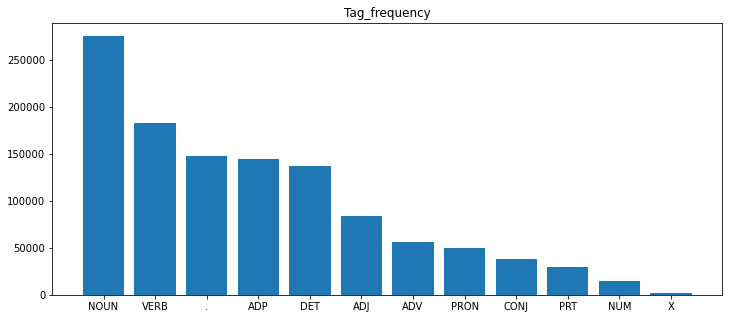

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.bar(tag_num.index, tag_num.values)
plt.title("Tag_frequency")
plt.show()

In [15]:
word_num[:5]

the    69971
,      58334
.      49346
of     36412
and    28853
dtype: int64

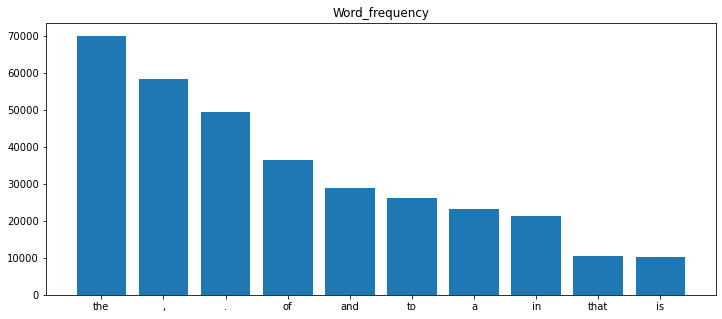

In [16]:
plt.figure(figsize=(12, 5))
plt.bar(word_num.index[:10], word_num.values[:10])
plt.title("Word_frequency")
plt.show()

### Вопрос 1:
* Кол-во слова `cat` в корпусе?

In [17]:
word_freq['cat']

23

### Вопрос 2:
* Самое популярное слово с самым популярным тегом? <br>(*сначала выбираете слова с самым популярным тегом, а затем выбираете самое популярное слово из уже выбранных*)

In [18]:
most_popular_tag = tag_freq.max()
words_freq_with_most_popular_tag = FreqDist(word for word, tag in brown_tagged_words if tag == most_popular_tag)
most_popular_word_with_most_popular_tag = words_freq_with_most_popular_tag.max()
most_popular_word_with_most_popular_tag, most_popular_tag

('time', 'NOUN')

Впоследствии обучение моделей может занимать слишком много времени, работайте с подвыборкой, например, только текстами определенных категорий.

Категории нашего корпуса:

In [19]:
brown.categories()

['adventure',
 'belles_lettres',
 'editorial',
 'fiction',
 'government',
 'hobbies',
 'humor',
 'learned',
 'lore',
 'mystery',
 'news',
 'religion',
 'reviews',
 'romance',
 'science_fiction']

Будем работать с категорией humor

Cделайте случайное разбиение выборки на обучение и контроль в отношении 9:1. 

In [20]:
brown_tagged_sents = brown.tagged_sents(tagset="universal", categories='humor')
# Приведем слова к нижнему регистру
my_brown_tagged_sents = []

for sent in brown_tagged_sents:
    my_brown_tagged_sents.append(list(map(lambda x: (x[0].lower(), x[1]), sent)))

from sklearn.model_selection import train_test_split

train_sents, test_sents = train_test_split(my_brown_tagged_sents, train_size=0.9, random_state=SEED)

In [21]:
len(train_sents)

947

In [22]:
len(test_sents)

106

### Метод максимального правдоподобия для обучения модели

* $\normalsize S = s_0, s_1, ..., s_N$ - скрытые состояния, то есть различные теги
* $\normalsize O = o_0, o_1, ..., o_M$ - различные слова
* $\normalsize a_{i,j} = p(s_j|s_i)$ - вероятность того, что, находясь в скрытом состоянии $s_i$, мы попадем в состояние $s_j$ (элемент матрицы $A$)
* $\normalsize b_{k,j}=p(o_k|s_j)$ - вероятность того, что при скрытом состоянии $s_j$ находится слово $o_k$(элемент матрицы $B$)

$$\normalsize x_t \in O, y_t \in S$$
$\normalsize (x_t, y_t)$ - слово и тег, стоящие на месте $t$ $\Rightarrow$ 
* $\normalsize X$ - последовательность слов
* $\normalsize Y$ - последовательность тегов

Требуется построить скрытую марковскую модель (class HiddenMarkovModel) и написать метод fit для настройки всех её параметров с помощью оценок максимального правдоподобия по размеченным данным (последовательности пар слово+тег):

- Вероятности переходов между скрытыми состояниями $p(y_t | y_{t - 1})$ посчитайте на основе частот биграмм POS-тегов.


- Вероятности эмиссий наблюдаемых состояний $p(x_t | y_t)$ посчитайте на основе частот "POS-тег - слово".


- Распределение вероятностей начальных состояний $p(y_0)$ задайте равномерным.

Пример $X = [x_0, x_1], Y = [y_0, y_1]$:<br><br>
$$p(X, Y) = p(x_0, x_1, y_0, y_1) = p(y_0) \cdot p(x_0, x_1, y_1 | y_0) = p(y_0) \cdot p(x_0 | y_0) \cdot p(x_1, y_1 | x_0, y_0) = \\ = p(y_0) \cdot p(x_0 | y_0) \cdot p(y_1 | x_0, y_0) \cdot p(x_1 | x_0, y_0, y_1) = (\text{в силу условий нашей модели}) = \\ = p(y_0) \cdot p(x_0 | y_0) \cdot p(y_1 | y_0) \cdot p(x_1 | y_1) \Rightarrow$$

Для последовательности длины $n + 1$:

$$p(X, Y) = p(x_0 ... x_{n - 1}, y_0 ... y_{n - 1}) \cdot p(y_n | y_{n - 1}) \cdot p(x_n | y_n)$$

#### Алгоритм Витерби для применения модели


Требуется написать метод .predict для определения частей речи на тестовой выборке. Чтобы использовать обученную модель на новых данных, необходимо реализовать алгоритм Витерби. Это алгоритм динамиеского программирования, с помощью которого мы будем находить наиболее вероятную последовательность скрытых состояний модели для фиксированной последовательности слов:

$$ \hat{Y} = \arg \max_{Y} p(Y|X) = \arg \max_{Y} p(Y, X) $$

Пусть $\normalsize Q_{t,s}$ - самая вероятная последовательность скрытых состояний длины $t$ с окончанием в состоянии $s$. $\normalsize q_{t, s}$ - вероятность этой последовательности.
$$(1)\: \normalsize q_{t,s} = \max_{s'} q_{t - 1, s'} \cdot p(s | s') \cdot p(o_t | s)$$
$\normalsize Q_{t,s}$ можно восстановить по argmax-ам.

In [23]:
from collections import Counter, deque

HiddenMarkovModel_PRINT_UNKNOWN = True

class HiddenMarkovModel:
    def fit(self, train_tokens_tags_list):
        """
        train_tokens_tags_list: массив предложений пар слово-тег (выборка для train) 
        """
        tags = [tag for sent in train_tokens_tags_list
                for (word, tag) in sent]
        words = [word for sent in train_tokens_tags_list
                 for (word, tag) in sent]
        
        tag_freq = Counter(tags)
        word_freq = Counter(words)
        tag_num = pd.Series(tag_freq).sort_index()
        word_num = pd.Series(word_freq).sort_values(ascending=False)

        # another way to do what nltk.FreqDist().max() does
        most_popular_tag = tag_freq.most_common(1)[0][0]
        words_freq_with_most_popular_tag = Counter(
                word for sent in train_tokens_tags_list
                for word, tag in sent if tag == most_popular_tag)
        most_popular_word_with_most_popular_tag = words_freq_with_most_popular_tag.most_common(1)[0][0]
        self._plug = most_popular_word_with_most_popular_tag
         
        self.tags = tag_num.index
        self.words = word_num.index
        
        A = pd.DataFrame({'{}'.format(tag) : [0] * len(tag_num) for tag in tag_num.index}, index=tag_num.index)
        B = pd.DataFrame({'{}'.format(tag) : [0] * len(word_num) for tag in tag_num.index}, index=word_num.index)
        
        # Вычисляем матрицу A и B по частотам слов и тегов
        
        # sent - предложение
        # sent[i][0] - i слово в этом предложении, sent[i][1] - i тег в этом предложении
        for sent in train_tokens_tags_list:
            last_tag_idx = len(sent) - 1
            for i, (word, tag) in enumerate(sent):
                B.loc[word, tag] += 1  # текущая i-пара слово-тег (обновите матрицу B аналогично A)
                if i != last_tag_idx:  # для последнего тега нет следующего тега
                    next_tag = sent[i + 1][1]
                    A.loc[tag, next_tag] += 1  # пара тег-тег

        # переходим к вероятностям
        
        # нормируем по строке, то есть по всем всевозможным следующим тегам
        A = A.divide(A.sum(axis=1), axis=0)
        
        # нормируем по столбцу, то есть по всем всевозможным текущим словам
        B = B.divide(B.sum(axis=0), axis=1)
        
        self.A = A
        self.B = B
        
        return self
        
    
    def predict(self, test_tokens_list):
        """
        test_tokens_list : массив предложений из списков слов (выборка для test)
        """
        predict_tags = []
        unknown_words = []
        for sent_idx, sent in enumerate(test_tokens_list):
            
            q = np.zeros(shape=(len(sent) + 1, len(self.tags)))
            q[0] = 1  # нулевое состояние (равномерная инициализация по всем s)
            back_point = np.zeros_like(q)  # argmax
            
            # word is an observed state.
            # word_idx + 1 matches probability of sequence of the current length
            # because q[0][...] matches empty sequence
            for word_idx, word in enumerate(sent):
                cur_seq_len = word_idx + 1
                
                # если мы не встречали такое слово в обучении, то вместо него будет 
                # самое популярное слово с самым популярным тегом (вопрос 2)
                if word not in self.words:
                    if HiddenMarkovModel_PRINT_UNKNOWN:
                        unknown_words.append(word)
                    word = self._plug
                    
                # через max выбираем следующий тег
                # tag is aka hidden state.
                # tag is possible tag for given word.
                for tag_idx, tag in enumerate(self.tags):
                    # формула (1)
                    q[cur_seq_len, tag_idx] = np.max(
                        q[word_idx] *
                        self.A.loc[:, tag] * 
                        self.B.loc[word, tag]
                    )
                    # argmax, чтобы восстановить последовательность тегов
                    back_point[cur_seq_len, tag_idx] = (
                        q[word_idx] *
                        self.A.loc[:, tag] * 
                        self.B.loc[word, tag]
                    ).reset_index()[tag].idxmax() # индекс 
                    
            back_point = back_point.astype('int')
            
            # выписываем теги, меняя порядок на реальный
            back_tag = deque()
            current_tag = np.argmax(q[len(sent)])
            for t in range(len(sent), 0, -1):
                back_tag.appendleft(self.tags[current_tag])
                current_tag = back_point[t, current_tag]

            predict_tags.append(np.array(back_tag))
        if HiddenMarkovModel_PRINT_UNKNOWN:
            print(f'Number of unknown words replaced with the plug "{self._plug}": {len(unknown_words)}.', end='\n\n')
            print(f'Those words: {unknown_words}', end='\n\n')
        return predict_tags                 

Обучите скрытую марковскую модель:

In [24]:
import time

start_time = time.time()
my_model = HiddenMarkovModel().fit(train_sents)
training_time = time.time() - start_time

Проверьте работу реализованного алгоритма на следующих модельных примерах, проинтерпретируйте результат.

- 'He can stay'
- 'a cat and a dog'
- 'I have a television'
- 'My favourite character'

In [25]:
sents = [['He', 'can', 'stay'], ['a', 'cat', 'and', 'a', 'dog'], ['I', 'have', 'a', 'television'],
         ['My', 'favourite', 'character']]
results = my_model.predict(sents)
results

Number of unknown words replaced with the plug "time": 5.

Those words: ['He', 'cat', 'I', 'My', 'favourite']



[array(['NOUN', 'VERB', 'VERB'], dtype='<U4'),
 array(['DET', 'NOUN', 'CONJ', 'DET', 'NOUN'], dtype='<U4'),
 array(['NOUN', 'VERB', 'DET', 'NOUN'], dtype='<U4'),
 array(['NOUN', 'NOUN', 'NOUN'], dtype='<U4')]

Для известных слов (были в тренировочном корпусе) теги предсказаны верно, для остальных тегом стал тег заглушки.

### Вопрос 3:
* Какой тег вы получили для слова `can`?

In [26]:
def find_word(sentences, word):
    for i, s in enumerate(sentences):
        for j, w in enumerate(s):
            if w == word:
                return i, j
    raise ValueError(f"cannot find {word} in given lists")

sent_idx, word_idx = find_word(sents, "can")
results[sent_idx][word_idx]

'VERB'

### Вопрос 4:
* Какой тег вы получили для слова `favourite`?

In [27]:
sent_idx, word_idx = find_word(sents, "favourite")
results[sent_idx][word_idx]

'NOUN'

Примените модель к отложенной выборке Брауновского корпуса и подсчитайте точность определения тегов (accuracy). Сделайте выводы. 

In [28]:
def accuracy_score(model, sents):
    true_pred = 0
    num_pred = 0
    tags = [np.array([tag for word, tag in sent]) for sent in sents]
    words = [[word for word, tag in sent] for sent in sents]
    predicted_tags = model.predict(words)
    for sent_tags, predicted_sent_tags in zip(tags, predicted_tags):
        true_pred += np.sum(sent_tags == predicted_sent_tags)
        num_pred += len(sent_tags)
    accuracy_score_in_percents = true_pred / num_pred * 100
    print("Accuracy:", accuracy_score_in_percents, '%')
    return accuracy_score_in_percents

In [29]:
start_time = time.time()
accuracy_on_test = accuracy_score(my_model, test_sents)
testing_time = time.time() - start_time

Number of unknown words replaced with the plug "time": 340.

Those words: ['frame', 'discovering', 'pleasantly', 'tingling', 'insinuations', 'handy', 'statement', 'doris', 'punishing', 'leads', 'neurenschatz', 'skolkau', 'gives', 'tremendously', 'inspired', 'rattzhenfuut', 'concertos', 'controversial', 'tschilwyk', 'cadenza', 'included', "conductor's", 'insistence', 'shifty', 'summoned', "who's", 'foot-loose', 'fancy-free', 'screw-loose', 'frenzy-free', 'debacle', 'unrepentant', 'badly', 'behaved', 'inscribed', 'balinese', 'dialect', 'comprehend', 'patronized', 'greenwich', 'artists', 'awhile', 'juncture', 'hotbed', 'gossip', 'precaution', 'whispered', 'alas', 'backwards', 'wiggled', 'rollickingly', 'grocery', 'youth', 'depressing', 'customers', 'sufficiently', 'neurotic', 'threat', 'incubi', 'alert', 'aspect', 'gravest', 'implications', 'beyond', 'legal', 'sanctions', 'inflict', 'similarly', 'reporter', 'questioned', 'lincoln', 'lincoln', 'statement', 'happily', 'bounds', 'throat', 'h

### Вопрос 5:
* Какое качество вы получили(округлите до одного знака после запятой)?

In [30]:
round(accuracy_on_test, 1)

88.8

In [31]:
experiment = "HiddenMarkovModel: humory category, train/test: 9/1"
add_experiment_results(experiment, accuracy_on_test, training_time, testing_time)
add_prediction_on_test_sentence(experiment, my_model)
HiddenMarkovModel_PRINT_UNKNOWN = False

Number of unknown words replaced with the plug "time": 3.

Those words: ['path', 'favourite', 'us.']



**Вывод:** почти 90% — неплохое качество. И, наверное, могло бы быть ещё лучше, если бы в разметке корпуса не было ошибок, подобных этим:

In [32]:
from collections import Counter

Counter(tag for word, tag in brown_tagged_words if word == 'to')

Counter({'PRT': 14995, 'ADP': 11158, 'NOUN': 1, 'X': 3, 'ADV': 1})

Кроме того, довольно значимая часть слов (~17%) из тестовой части не встречалась в тренировочном корпусе. Они были заменены заглушкой (самое популярное слово с самым популярным тегом), тег которой далеко не всегда совпадал с тегом неизвестного слова (см. выше их точное количество и полный список):

In [33]:
340 / sum(map(len, test_sents))

0.16806722689075632

## DefaultTagger

### Вопрос 6:
* Какое качество вы бы получили, если бы предсказывали любой тег, как самый популярный тег на выборке train(округлите до одного знака после запятой)?

Вы можете испоьзовать DefaultTagger(метод tag для предсказания частей речи предложения)

In [34]:
from nltk.tag import DefaultTagger

default_tagger = DefaultTagger(most_popular_tag)

In [35]:
class TaggerModel:
    def __init__(self, tagger):
        self._tagger = tagger

    def predict(self, test_tokens_list):
        predicted_tags = []
        for sent in self._tagger.tag_sents(test_tokens_list):
            predicted_tags.append(np.array([tag for word, tag in sent]))
        return predicted_tags

model = TaggerModel(default_tagger)
round(accuracy_score(model, test_sents), 1)

Accuracy: 20.217498764211566 %


20.2

## NLTK, Rnnmorph

Вспомним первый [семинар](https://colab.research.google.com/drive/1FHZVU6yJT61J8w1hALno0stD4VU36rit?usp=sharing) нашего курса. В том семинаре мы с вами работали c некоторыми библиотеками.

Не забудьте преобразовать систему тэгов из `'en-ptb' в 'universal'` с помощью функции `map_tag` или используйте `tagset='universal'`

In [36]:
from nltk.tag.mapping import map_tag

In [37]:
how_many = None
test_words = [[word for word, _ in sent] for sent in test_sents[:how_many]]
test_tags = [[tag for _, tag in sent] for sent in test_sents[:how_many]]

In [38]:
%%time
import nltk

nltk.download('averaged_perceptron_tagger')
nltk_results = [[tag for _, tag in sent] for sent in nltk.pos_tag_sents(test_words, tagset='universal')]

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\user0\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
Wall time: 405 ms


In [39]:
warnings.filterwarnings("ignore", module="tensorflow", category=DeprecationWarning)

In [40]:
%%time

from rnnmorph.predictor import RNNMorphPredictor

predictor = RNNMorphPredictor(language="en")

rnnmorph_results = [[form.pos for form in sent] for sent in predictor.predict_sentences(test_words)]

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\user0\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\user0\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     C:\Users\user0\AppData\Roaming\nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!
Wall time: 12.5 s


### Вопрос 7:
* Какое качество вы получили, используя каждую из двух библиотек? Сравните их результаты.

* Качество с библиотекой rnnmorph должно быть хуже, так как там используется немного другая система тэгов. Какие здесь отличия?

In [41]:
import numpy as np

def accuracy(true_tags, predicted_tags):
    if len(true_tags) != len(predicted_tags):
        raise ValueError("numbers of sentences are not equal")
    total = true = 0
    for true_tags_sent, predicted_tags_sent in zip(true_tags, predicted_tags):
        if len(true_tags_sent) != len(predicted_tags_sent):
            raise ValueError("lenghts of sentences are not equal")
        if not isinstance(true_tags_sent, np.ndarray):
            true_tags_sent = np.array(true_tags_sent)
        if not isinstance(predicted_tags_sent, np.ndarray):
            predicted_tags_sent = np.array(predicted_tags_sent)
        total += len(true_tags_sent)
        true += np.sum(true_tags_sent == predicted_tags_sent)
    return true / total * 100

In [42]:
print(f"Accuracy with nltk: {accuracy(test_tags, nltk_results):.3f}%")
print(f"Accuracy with rnnmorph: {accuracy(test_tags, rnnmorph_results):.3f}%")

Accuracy with nltk: 89.224%
Accuracy with rnnmorph: 63.223%


`nltk` под `tagset='universal'` подразумевает **Google universal tags** (см. [таблицу](http://www.nltk.org/book/ch05.html#tab-universal-tagset) и [paper](https://arxiv.org/abs/1104.2086) "A Universal Part-of-Speech Tagset"):
> Tagged corpora use many different conventions for tagging words. To help us get started, we will be looking at a simplified tagset (shown in 2.1).

`rnnmorph` использует набор тегов из **Universal Dependecies** (см. [таблицу](https://universaldependencies.org/u/pos/)). Этот набор есть [эволюционное объединение](https://universaldependencies.org/introduction.html) нескольких других систем:
> The annotation scheme is based on an evolution of (universal) Stanford dependencies (de Marneffe et al., 2006, 2008, 2014), Google universal part-of-speech tags (Petrov et al., 2012), and the Interset interlingua for morphosyntactic tagsets (Zeman, 2008).

И, насколько я понимаю, прямого отображения на теги из **UD** не существует:
> The first version of the new guidelines, released in October 2014, introduced a somewhat extended universal part-of-speech tag set. This set makes some distinctions that were missing in the original proposal, but were perceived to be of importance by many, and clarifies the definition of categories. As a result of this work, universal POS categories have substantive definitions and are not necessarily just equivalence classes of categories in underlying language-particular treebanks. Hence, work to convert to UD POS tags often requires context-sensitive rules, or some hand correction.

Но есть [руководство](https://universaldependencies.org/u/pos/all.html) по разметке, исходя из которого можно сделать некоторые предположения:

(Universal Dependecies POS tags -> Google POS universal tags)
- AUX, VERB -> VERB
- CCONJ, SCONJ -> CONJ
- INTJ -> X
- PART -> PRT
- PROPN, NOUN -> NOUN
- PUNCT	-> .
- SYM -> X


- ADJ -> ADJ
- ADP -> ADP
- ADV -> ADV
- DET -> DET
- NUM -> NUM
- X -> X

Поскольку ground truth у нас в `nltk`-simplified tags (**Google Unviersal POS tags**), оценка качества `rnnmorph`-результатов значительно ниже. Можно попытаться конвертировать результаты `rnnmorph` в **Google POS universal tags**:

In [43]:
ud_to_google_mapping = {
    "ADJ": "ADJ",
    "ADP": "ADP",
    "ADV": "ADV",
    "AUX": "VERB",
    "CCONJ": "CONJ",
    "DET": "DET",
    "INTJ": "X",
    "NOUN": "NOUN",
    "NUM": "NUM",
    "PART": "PRT",
    "PRON": "PRON",
    "PROPN": "NOUN",
    "PUNCT": ".",
    "SCONJ": "CONJ",
    "SYM": "X",
    "VERB": "VERB",
    "X": "X"
}

def from_ud_to_google(ud_tag):
    try:
        return ud_to_google_mapping[ud_tag]
    except KeyError:
        raise ValueError(f"'{ud_tag}' is not in Universal Dependencies Tagset")

In [44]:
rnnmorph_results_converted = [[from_ud_to_google(tag) for tag in sent] for sent in rnnmorph_results]
print(f"Accuracy with converted rnnmorph: {accuracy(test_tags, rnnmorph_results_converted):.3f}%")

Accuracy with converted rnnmorph: 89.323%


Таким образом, на самом деле `rnnmorph` отработал даже чуть лучше `nltk`.

## BiLSTMTagger

### Подготовка данных

Изменим структуру данных

In [45]:
brown_tagged_sents = brown.tagged_sents(tagset="universal", categories="humor")

In [46]:
pos_data = [list(zip(*sent)) for sent in brown_tagged_sents]
print(pos_data[0])

[('It', 'was', 'among', 'these', 'that', 'Hinkle', 'identified', 'a', 'photograph', 'of', 'Barco', '!', '!'), ('PRON', 'VERB', 'ADP', 'DET', 'ADP', 'NOUN', 'VERB', 'DET', 'NOUN', 'ADP', 'NOUN', '.', '.')]


До этого мы писали много кода сами, теперь пора эксплуатировать pytorch

Теперь формируем наш датасет

In [47]:
import torchtext
from torch.utils.data import random_split

train_len = int(len(pos_data) * 0.8)
valid_len = int(len(pos_data) * 0.1)
test_len = len(pos_data) - (train_len + valid_len)
train_data, valid_data, test_data = random_split(pos_data, lengths=(train_len, valid_len, test_len))

print(f"Number of training examples: {len(train_data)}")
print(f"Number of validation examples: {len(valid_data)}")
print(f"Number of testing examples: {len(test_data)}")

Number of training examples: 842
Number of validation examples: 105
Number of testing examples: 106


Построим словари. Параметр `min_freq` выберете сами. При построении словаря испольузем только **train**

In [48]:
from collections import Counter
from itertools import chain

from torchtext.vocab import Vocab

PAD_TOKEN = '<pad>'  # default special padding token in Vocab
UNK_TOKEN = '<unk>'  # default special token for unknown tokens in Vocab

words_counter = Counter(chain.from_iterable(map(lambda w: w.lower(), words) for words, _ in train_data))
words_vocab = Vocab(words_counter, min_freq=1, specials=(PAD_TOKEN, UNK_TOKEN))

tags_counter = Counter(chain.from_iterable(tags for _, tags in train_data))
tags_vocab = Vocab(tags_counter, min_freq=1, specials=(PAD_TOKEN,))

assert words_vocab.stoi[PAD_TOKEN] == tags_vocab.stoi[PAD_TOKEN]
PAD_IDX = words_vocab.stoi[PAD_TOKEN]

print(f"Unique tokens in words vocabulary: {len(words_vocab)}")
print(f"Unique tokens in tags vocabulary: {len(tags_vocab)}")

print(words_vocab.itos[::200])
print(tags_vocab.itos)

Unique tokens in words vocabulary: 4102
Unique tokens in tags vocabulary: 13
['<pad>', 'almost', 'character', 'hollywood', 'breath', 'jump', 'sober', 'antique', 'bravado', 'confidential', 'distinct', 'fast', 'guys', 'inventory', 'marriages', 'opalescent', 'produce', 'romances', 'slight', 'thalbergs', 'voted']
['<pad>', 'NOUN', 'VERB', '.', 'DET', 'ADP', 'ADJ', 'PRON', 'ADV', 'CONJ', 'PRT', 'NUM', 'X']


In [49]:
print(train_data[9])

[("you're", 'tooling', 'around', 'full', 'of', 'gage', 'in', 'your', 'hot', 'rods', ',', 'gorging', 'yourselves', 'on', 'pizza', 'and', 'playing', 'pinball', 'in', 'the', 'taverns', 'and', 'generally', 'behaving', 'like', 'Ubermenschen', '.'), ('PRT', 'VERB', 'ADV', 'ADJ', 'ADP', 'NOUN', 'ADP', 'DET', 'ADJ', 'NOUN', '.', 'VERB', 'PRON', 'ADP', 'NOUN', 'CONJ', 'VERB', 'NOUN', 'ADP', 'DET', 'NOUN', 'CONJ', 'ADV', 'VERB', 'ADP', 'X', '.')]


Посмотрим с насколько большими предложениями мы имеем дело

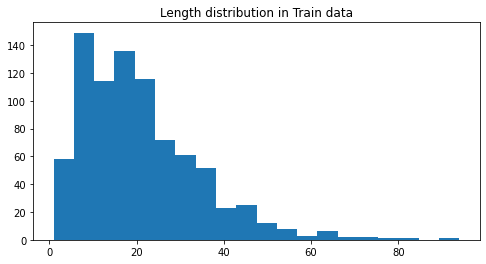

In [50]:
length = map(lambda words_tags: len(words_tags[0]), train_data)

plt.figure(figsize=[8, 4])
plt.title("Length distribution in Train data")
plt.hist(list(length), bins=20);

Для обучения `BiLSTM` лучше использовать colab

In [51]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [52]:
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

def labels_transform(labels):
    return [tags_vocab.stoi[label] for label in labels]

def labels_inverse_transform(indices):
    return [tags_vocab.itos[label] for idx in indices]

def tokens_transform(tokens, lower=True):
    if lower:
        tokens = (token.lower() for token in tokens)
    return [words_vocab.stoi[token] for token in tokens]

def collate_batch(batch):
    labels_list, tokens_list = [], []
    for tokens, labels in batch:
        labels_indices = labels_transform(labels)
        labels_list.append(torch.tensor(labels_indices))
        tokens_indices = tokens_transform(tokens)
        tokens_list.append(torch.tensor(tokens_indices))
    return {
        "tokens": pad_sequence(tokens_list, batch_first=True, padding_value=PAD_IDX),
        "labels": pad_sequence(labels_list, batch_first=True, padding_value=PAD_IDX)
    }

BATCH_SIZE = 32

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, collate_fn=collate_batch, shuffle=True, drop_last=True)
valid_loader = DataLoader(valid_data, batch_size=BATCH_SIZE, collate_fn=collate_batch)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, collate_fn=collate_batch)

In [53]:
# посморим  на количество батчей
list(map(len, [train_loader, valid_loader, test_loader]))

[26, 4, 4]

### Модель и её обучение

Инициализируем нашу модель

In [54]:
from torch import nn

class LSTMTagger(nn.Module):

    def __init__(self, input_dim, emb_dim, hid_dim, output_dim, emb_dropout, bidirectional=False, padding_idx=None, num_layers=1, hidden_dropout=None):
        super().__init__()
        
        self.embedding = nn.Embedding(num_embeddings=input_dim, embedding_dim=emb_dim, padding_idx=padding_idx)
        self.dropout = nn.Dropout(emb_dropout)
        
        self.rnn = nn.LSTM(input_size=emb_dim, hidden_size=hid_dim, bidirectional=bidirectional, num_layers=num_layers, dropout=hidden_dropout, batch_first=True)
        # если bidirectional, то предсказываем на основе конкатенации двух hidden
        self.tag = nn.Linear((1 + bidirectional) * hid_dim, output_dim)

    def forward(self, sent):
        embedded = self.embedding(sent)
        dropped = self.dropout(embedded)
        output, _ = self.rnn(dropped)
        prediction = self.tag(output)
        return prediction
        
# параметры модели
INPUT_DIM = len(words_vocab)
OUTPUT_DIM = len(tags_vocab)
EMB_DIM = 300
HID_DIM = 50
EMB_DROPOUT = 0.5
BIDIRECTIONAL = True
NUM_LAYERS = 1
HIDDEN_DROPOUT = 0
model = LSTMTagger(INPUT_DIM, EMB_DIM, HID_DIM, OUTPUT_DIM, EMB_DROPOUT, BIDIRECTIONAL, PAD_IDX, NUM_LAYERS, HIDDEN_DROPOUT).to(device)

# инициализируем веса
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param, -0.08, 0.08)
        
model.apply(init_weights)

LSTMTagger(
  (embedding): Embedding(4102, 300, padding_idx=0)
  (dropout): Dropout(p=0.5, inplace=False)
  (rnn): LSTM(300, 50, batch_first=True, bidirectional=True)
  (tag): Linear(in_features=100, out_features=13, bias=True)
)

Подсчитаем количество обучаемых параметров нашей модели

In [55]:
def count_parameters(model):
    return sum(map(lambda x: x.numel(), model.parameters()))

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 1,372,713 trainable parameters


Погнали обучать

In [56]:
def train(model, iterator, optimizer, criterion, clip, device, train_history=None, valid_history=None):
    model.train()
    
    epoch_loss = 0
    history = []
    for i, batch in enumerate(iterator):
        
        tokens = batch["tokens"].to(device)
        labels = batch["labels"].to(device)
        
        optimizer.zero_grad()
        output = model(tokens)
        reshaped_output = output.view(-1, output.size(-1))
        reshaped_labels = labels.view(-1)
        loss = criterion(reshaped_output, reshaped_labels)
        
        loss.backward()
        # Gradient clipping(решение проблемы взрыва граденты), clip - максимальная норма вектора
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=clip)
        optimizer.step()
        epoch_loss += loss.item()
        history.append(loss.item())

        if (i+1)%10==0:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))
            clear_output(True)
            ax[0].plot(history, label='train loss')
            ax[0].set_xlabel('Batch')
            ax[0].set_title('Train loss')
            if train_history is not None:
                ax[1].plot(train_history, label='general train history')
                ax[1].set_xlabel('Epoch')
            if valid_history is not None:
                ax[1].plot(valid_history, label='general valid history')
            plt.legend()
            plt.show()

    return epoch_loss / len(iterator)

@torch.no_grad()
def evaluate(model, iterator, criterion, device):
    model.eval()
    epoch_loss = 0
    for i, batch in enumerate(iterator):
        tokens = batch["tokens"].to(device)
        labels = batch["labels"].to(device)
        output = model(tokens)
        reshaped_output = output.view(-1, output.size(-1))
        reshaped_labels = labels.view(-1)
        loss = criterion(reshaped_output, reshaped_labels)
        epoch_loss += loss.item()
    return epoch_loss / len(iterator)

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [57]:
import math
import time

import matplotlib
import matplotlib.pyplot as plt
from IPython.display import clear_output
from torch import optim

matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
%matplotlib inline

def train_valid_model(model, num_epochs, train_loader, valid_loader, optimizer, criterion, max_grad_norm, device):
    train_history = []
    valid_history = []
    best_valid_loss = float('inf')
    for epoch in range(num_epochs):
        
        start_time = time.time()
        
        train_loss = train(model, train_loader, optimizer, criterion, max_grad_norm, device, train_history, valid_history)
        valid_loss = evaluate(model, valid_loader, criterion, device)
        
        end_time = time.time()
        
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), 'best-val-model.pt')

        train_history.append(train_loss)
        valid_history.append(valid_loss)
        print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

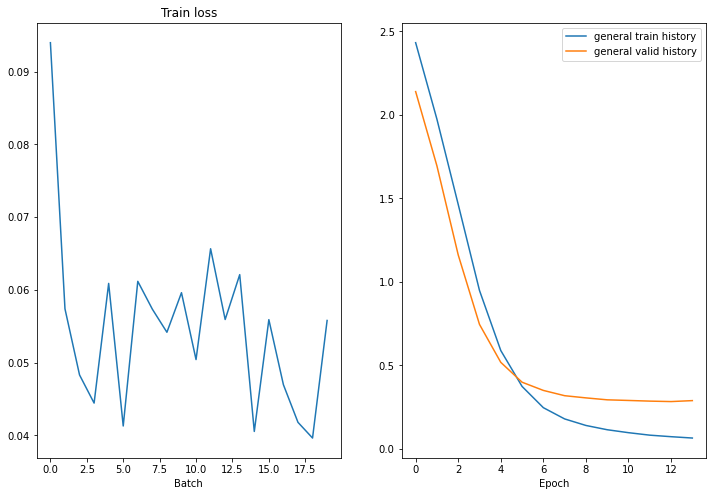

Epoch: 15 | Time: 0m 1s
	Train Loss: 0.057 | Train PPL:   1.059
	 Val. Loss: 0.283 |  Val. PPL:   1.327


In [58]:
enable_reproducibility()

model = LSTMTagger(INPUT_DIM, EMB_DIM, HID_DIM, OUTPUT_DIM, EMB_DROPOUT, BIDIRECTIONAL, PAD_IDX, NUM_LAYERS, HIDDEN_DROPOUT).to(device)
model.apply(init_weights)
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)

N_EPOCHS = 15
CLIP = 2

start_time = time.time()
train_valid_model(model, N_EPOCHS, train_loader, valid_loader, optimizer, criterion, CLIP, device)
training_time = time.time() - start_time

### Применение модели

In [59]:
@torch.no_grad()
def accuracy_model(model, iterator):
    model.eval()
    true_pred = 0
    num_pred = 0
    for i, batch in enumerate(iterator):
        tokens = batch["tokens"].to(device)
        labels = batch["labels"].to(device)
        output = model(tokens)
        predict_tags = output.argmax(dim=-1).cpu().numpy()
        true_tags = labels.cpu().numpy()
        true_pred += np.sum((true_tags == predict_tags) & (true_tags != PAD_IDX))
        num_pred += np.prod(true_tags.shape) - (true_tags == PAD_IDX).sum()
    return true_pred / num_pred * 100

In [60]:
model.load_state_dict(torch.load('best-val-model.pt'))
start_time = time.time()
accuracy_on_test = accuracy_model(model, test_loader)
print("Accuracy:", round(accuracy_on_test, 3), '%')
testing_time = time.time() - start_time

Accuracy: 90.345 %


In [61]:
experiment = (f"LSTMTagger: humor cat, train/val/test: 8/1/1, epochs (might stop earlier): {N_EPOCHS}, emb: {EMB_DIM}, emb dropout: {EMB_DROPOUT}, hidden: {HID_DIM}, bidirect: {BIDIRECTIONAL}, layers: {NUM_LAYERS}, hidden dropout: {HIDDEN_DROPOUT}")
add_experiment_results(experiment, accuracy_on_test, training_time, testing_time)
add_prediction_on_test_sentence(experiment, model, device)

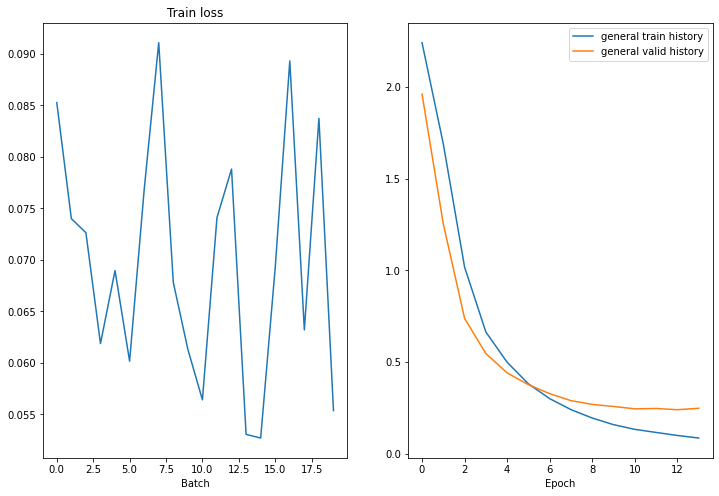

Epoch: 15 | Time: 0m 1s
	Train Loss: 0.072 | Train PPL:   1.074
	 Val. Loss: 0.231 |  Val. PPL:   1.259
Accuracy: 92.13 %


In [62]:
INPUT_DIM = len(words_vocab)
OUTPUT_DIM = len(tags_vocab)
EMB_DIM = 300
HID_DIM = 150
EMB_DROPOUT = 0.8
BIDIRECTIONAL = True
NUM_LAYERS = 1
HIDDEN_DROPOUT = 0

enable_reproducibility()
model = LSTMTagger(INPUT_DIM, EMB_DIM, HID_DIM, OUTPUT_DIM, EMB_DROPOUT, BIDIRECTIONAL, PAD_IDX, NUM_LAYERS, HIDDEN_DROPOUT).to(device)
model.apply(init_weights)
optimizer = optim.Adam(model.parameters())

N_EPOCHS = 15

start_time = time.time()
train_valid_model(model, N_EPOCHS, train_loader, valid_loader, optimizer, criterion, CLIP, device)
training_time = time.time() - start_time

model.load_state_dict(torch.load('best-val-model.pt'))
start_time = time.time()
accuracy_on_test = accuracy_model(model, test_loader)
print("Accuracy:", round(accuracy_on_test, 3), '%')
testing_time = time.time() - start_time

In [63]:
experiment = (f"LSTMTagger: humor cat, train/val/test: 8/1/1, epochs (might stop earlier): {N_EPOCHS}, emb: {EMB_DIM}, emb dropout: {EMB_DROPOUT}, hidden: {HID_DIM}, bidirect: {BIDIRECTIONAL}, layers: {NUM_LAYERS}, hidden dropout: {HIDDEN_DROPOUT}")
add_experiment_results(experiment, accuracy_on_test, training_time, testing_time)
add_prediction_on_test_sentence(experiment, model, device)

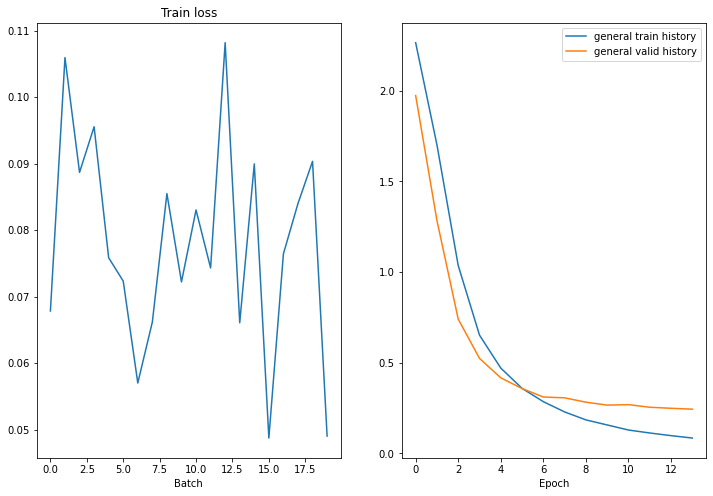

Epoch: 15 | Time: 0m 1s
	Train Loss: 0.077 | Train PPL:   1.080
	 Val. Loss: 0.254 |  Val. PPL:   1.289
Accuracy: 91.724 %


In [64]:
# the same settings but with another seed

enable_reproducibility(seed=42)
model = LSTMTagger(INPUT_DIM, EMB_DIM, HID_DIM, OUTPUT_DIM, EMB_DROPOUT, BIDIRECTIONAL, PAD_IDX, NUM_LAYERS, HIDDEN_DROPOUT).to(device)
model.apply(init_weights)
optimizer = optim.Adam(model.parameters())

start_time = time.time()
train_valid_model(model, N_EPOCHS, train_loader, valid_loader, optimizer, criterion, CLIP, device)
training_time = time.time() - start_time

model.load_state_dict(torch.load('best-val-model.pt'))
start_time = time.time()
accuracy_on_test = accuracy_model(model, test_loader)
print("Accuracy:", round(accuracy_on_test, 3), '%')
testing_time = time.time() - start_time

In [65]:
experiment = (f"LSTMTagger: humor cat, train/val/test: 8/1/1, epochs (might stop earlier): {N_EPOCHS}, emb: {EMB_DIM}, emb dropout: {EMB_DROPOUT}, hidden: {HID_DIM}, bidirect: {BIDIRECTIONAL}, layers: {NUM_LAYERS}, hidden dropout: {HIDDEN_DROPOUT} (another seed)")
add_experiment_results(experiment, accuracy_on_test, training_time, testing_time)
add_prediction_on_test_sentence(experiment, model, device)

Вы можете улучшить качество, изменяя параметры модели. Но чтобы добиться нужного качества, вам неообходимо взять все выборку, а не только категорию `humor`.

In [66]:
brown_tagged_sents = brown.tagged_sents(tagset="universal")

In [67]:
my_brown_tagged_sents = []

for sent in brown_tagged_sents:
    my_brown_tagged_sents.append(list(map(lambda x: (x[0].lower(), x[1]), sent)))

train_sents, test_sents = train_test_split(my_brown_tagged_sents, train_size=0.9, random_state=SEED)

start_time = time.time()
my_model = HiddenMarkovModel().fit(train_sents)
training_time = time.time() - start_time

start_time = time.time()
accuracy_on_test = accuracy_score(my_model, test_sents)
testing_time = time.time() - start_time

experiment = "HiddenMarkovModel: all categories, train/test: 9/1"
add_experiment_results(experiment, accuracy_on_test, training_time, testing_time)
add_prediction_on_test_sentence(experiment, my_model)

Accuracy: 96.26295331104619 %


In [68]:
pos_data = [list(zip(*sent)) for sent in brown_tagged_sents]


train_len = int(len(pos_data) * 0.8)
valid_len = int(len(pos_data) * 0.1)
test_len = len(pos_data) - (train_len + valid_len)
train_data, valid_data, test_data = random_split(pos_data, lengths=(train_len, valid_len, test_len))


words_counter = Counter(chain.from_iterable(map(lambda w: w.lower(), words) for words, _ in train_data))
words_vocab = Vocab(words_counter, min_freq=1, specials=(PAD_TOKEN, UNK_TOKEN))

tags_counter = Counter(chain.from_iterable(tags for _, tags in train_data))
tags_vocab = Vocab(tags_counter, min_freq=1, specials=(PAD_TOKEN,))

assert words_vocab.stoi[PAD_TOKEN] == tags_vocab.stoi[PAD_TOKEN]
PAD_IDX = words_vocab.stoi[PAD_TOKEN]


BATCH_SIZE = 32
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, collate_fn=collate_batch, shuffle=True, drop_last=True)
valid_loader = DataLoader(valid_data, batch_size=BATCH_SIZE, collate_fn=collate_batch)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, collate_fn=collate_batch)

list(map(len, [train_loader, valid_loader, test_loader]))

[1433, 180, 180]

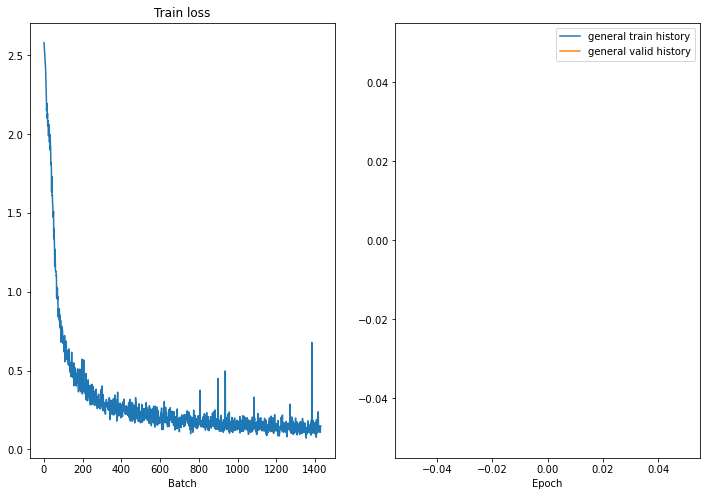

Epoch: 01 | Time: 2m 7s
	Train Loss: 0.307 | Train PPL:   1.359
	 Val. Loss: 0.104 |  Val. PPL:   1.110
Accuracy: 96.62 %


In [69]:
enable_reproducibility()

INPUT_DIM = len(words_vocab)
OUTPUT_DIM = len(tags_vocab)

model = LSTMTagger(INPUT_DIM, EMB_DIM, HID_DIM, OUTPUT_DIM, EMB_DROPOUT, BIDIRECTIONAL, PAD_IDX, NUM_LAYERS, HIDDEN_DROPOUT).to(device)
model.apply(init_weights)
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)

N_EPOCHS = 1

start_time = time.time()
train_valid_model(model, N_EPOCHS, train_loader, valid_loader, optimizer, criterion, CLIP, device)
training_time = time.time() - start_time

model.load_state_dict(torch.load('best-val-model.pt'))
start_time = time.time()
accuracy_on_test = accuracy_model(model, test_loader)
print("Accuracy:", round(accuracy_on_test, 3), '%')
testing_time = time.time() - start_time

experiment = (f"LSTMTagger: all cats, train/val/test: 8/1/1, epochs (might stop earlier): {N_EPOCHS}, emb: {EMB_DIM}, emb dropout: {EMB_DROPOUT}, hidden: {HID_DIM}, bidirect: {BIDIRECTIONAL}, layers: {NUM_LAYERS}, hidden dropout: {HIDDEN_DROPOUT}")
add_experiment_results(experiment, accuracy_on_test, training_time, testing_time)
add_prediction_on_test_sentence(experiment, model, device)

Вам неоходимо добиться качества не меньше, чем `accuracy = 93 %` 

In [70]:
best_model = LSTMTagger(INPUT_DIM, EMB_DIM, HID_DIM, OUTPUT_DIM, EMB_DROPOUT, BIDIRECTIONAL, PAD_IDX, NUM_LAYERS, HIDDEN_DROPOUT).to(device)
best_model.load_state_dict(torch.load('best-val-model.pt'))
assert accuracy_model(best_model, test_loader) >= 93

Пример решение нашей задачи:

In [71]:
def print_tags(model, sentence, device, batch_first=True):
    if isinstance(sentence, str):
        raise ValueError("sentence must be tokenized")
    if isinstance(sentence[0], str):
        words = sentence
    else:
        words, _ = sentence
    tags = predict_tags(model, sentence, device, batch_first)
    for token, tag in zip(words, tags):
        print(f'{token:15s}\t{tag}')

In [72]:
words_vocab["favourite"] == words_vocab[UNK_TOKEN]

True

In [73]:
words_vocab["favorite"] == words_vocab[UNK_TOKEN]

False

In [74]:
# incorrect for my model, sometimes (especially when model trained on small data) results in
# different prediction because prediction is based on single element sequence
print_tags(model, test_sentence, device, batch_first=False)  

He             	PRON
walked         	VERB
along          	ADP
the            	DET
path           	NOUN
in             	ADP
his            	DET
favourite      	VERB
park           	NOUN
in             	ADP
England        	NOUN
and            	CONJ
thought        	VERB
about          	ADP
favorite       	ADJ
book           	NOUN
he             	PRON
bought         	VERB
in             	ADP
the            	DET
US.            	VERB


In [75]:
# correct: please give attention to "favourite".
# Model predicted the correct tag for the unknown word.
print_tags(model, test_sentence, device)

He             	PRON
walked         	VERB
along          	ADP
the            	DET
path           	NOUN
in             	ADP
his            	DET
favourite      	ADJ
park           	NOUN
in             	ADP
England        	NOUN
and            	CONJ
thought        	VERB
about          	ADV
favorite       	ADJ
book           	NOUN
he             	PRON
bought         	VERB
in             	ADP
the            	DET
US.            	NOUN


## Сравните результаты моделей HiddenMarkov, LstmTagger:
* при обучение на маленькой части корпуса, например, на категории humor
* при обучении на всем корпусе

In [76]:
get_experiments_results_table()

,test accuracy,training time,testing time
experiment,,,
"HiddenMarkovModel: humory category, train/test: 9/1",88.828473,7.788690,43.075915
"LSTMTagger: humor cat, train/val/test: 8/1/1, epochs (might stop earlier): 15, emb: 300, emb dropout: 0.5, hidden: 50, bidirect: True, layers: 1, hidden dropout: 0",90.344828,28.906289,0.022933
"LSTMTagger: humor cat, train/val/test: 8/1/1, epochs (might stop earlier): 15, emb: 300, emb dropout: 0.8, hidden: 150, bidirect: True, layers: 1, hidden dropout: 0",92.129817,24.828006,0.020999
"LSTMTagger: humor cat, train/val/test: 8/1/1, epochs (might stop earlier): 15, emb: 300, emb dropout: 0.8, hidden: 150, bidirect: True, layers: 1, hidden dropout: 0 (another seed)",91.724138,25.490155,0.018999
"HiddenMarkovModel: all categories, train/test: 9/1",96.262953,464.365630,2839.527782
"LSTMTagger: all cats, train/val/test: 8/1/1, epochs (might stop earlier): 1, emb: 300, emb dropout: 0.8, hidden: 150, bidirect: True, layers: 1, hidden dropout: 0",96.619801,127.956837,1.005562


Первое, что бросается в глаза — время обучения и инференса. Скрытая марковская модель учится дольше на хоть сколь-нибудь больших данных, а её инференс вообще превышает разумные пределы. Обучение по сути представляет собой запоминание обучающей выборки, инференс — алгоритм динамического программирования (алгоритм Витерби) — имеет линейную от длины последовательности сложность, но с достаточно большим коэффициентом (число тегов в квадрате), что, наверное, в сочетании с питоновскими циклами и пресловутым GIL является причиной такой медленной работы. Нейронные сети с маленьким количеством тренировочных данных требуют несколько эпох обучения, но в целом учатся быстро, а инференс вообще молниеносный.

Если судить по accuracy, качество разметки нейронками выше, особенно на маленьких наборах данных, но только если подобрать правильные параметры, которые предотвратят переобучение. Дропаут после эмбеддингов, видимо, заставляет модель меньше полагаться на особенности (признаки) слов и больше на их порядок, что важно при малом наборе тренировочных данных, т.к. не позволяет модели зацикливаться на уже изученных словах. Из значений accuracy очевидна важность размера тренировочной выборки: обучение стабильнее и быстрее, качество результатов выше. На маленьком датасете такого не добиться никакими ухищрениями с регуляризацией.

На большом датасете марковская модель подбирается близко к нейронке по accuracy. Причина, вероятно, в получении более близкого к реальному распределения вероятностей в матрицах переходов состояний.

In [77]:
pd.set_option("max_columns", None)
get_predictions_results_table()

,He,walked,along,the,path,in,his,favourite,park,in,England,and,thought,about,favorite,book,he,bought,in,the,US.
experiment,,,,,,,,,,,,,,,,,,,,,
"HiddenMarkovModel: humory category, train/test: 9/1",PRON,VERB,ADP,DET,NOUN,ADP,DET,NOUN,NOUN,ADP,NOUN,CONJ,VERB,ADP,ADJ,NOUN,PRON,VERB,ADP,DET,NOUN
"LSTMTagger: humor cat, train/val/test: 8/1/1, epochs (might stop earlier): 15, emb: 300, emb dropout: 0.5, hidden: 50, bidirect: True, layers: 1, hidden dropout: 0",PRON,VERB,ADP,DET,NOUN,ADP,DET,NOUN,NOUN,ADP,NOUN,CONJ,VERB,ADP,VERB,NOUN,PRON,VERB,ADP,DET,NOUN
"LSTMTagger: humor cat, train/val/test: 8/1/1, epochs (might stop earlier): 15, emb: 300, emb dropout: 0.8, hidden: 150, bidirect: True, layers: 1, hidden dropout: 0",PRON,VERB,ADP,DET,NOUN,ADP,DET,ADJ,NOUN,ADP,NOUN,CONJ,VERB,ADP,ADJ,NOUN,PRON,VERB,ADP,DET,NOUN
"LSTMTagger: humor cat, train/val/test: 8/1/1, epochs (might stop earlier): 15, emb: 300, emb dropout: 0.8, hidden: 150, bidirect: True, layers: 1, hidden dropout: 0 (another seed)",PRON,VERB,ADP,DET,NOUN,ADP,DET,NOUN,NOUN,ADP,NOUN,CONJ,VERB,ADP,ADJ,NOUN,PRON,VERB,ADP,DET,NOUN
"HiddenMarkovModel: all categories, train/test: 9/1",PRON,VERB,ADP,DET,NOUN,ADP,DET,NOUN,NOUN,ADP,NOUN,CONJ,VERB,ADV,ADJ,NOUN,PRON,VERB,ADP,DET,NOUN
"LSTMTagger: all cats, train/val/test: 8/1/1, epochs (might stop earlier): 1, emb: 300, emb dropout: 0.8, hidden: 150, bidirect: True, layers: 1, hidden dropout: 0",PRON,VERB,ADP,DET,NOUN,ADP,DET,ADJ,NOUN,ADP,NOUN,CONJ,VERB,ADV,ADJ,NOUN,PRON,VERB,ADP,DET,NOUN


В данном примере предсказания моделей отличаются только на favourite (нет в словаре) и favorite (есть в словаре).

Вторая модель ошиблась на favorite, после подгонки параметров в последующих моделях предсказания верные. Случай с favourite интереснее. Марковская модель использует заглушку, POS которой совпадает с предсказанием (самый популярный тег — NOUN):


In [78]:
my_model._plug

'time'

А нейронка вывела тег из контекста, поскольку сам по себе токен-заглушку она считает глаголом:

In [79]:
UNK_TOKEN, predict_tags(model, [UNK_TOKEN], device)

('<unk>', ['VERB'])

Впрочем, этот результат (предсказание нейронкой верного токена для favourite), как видно из таблицы, не стабилен по крайней мере при обучении на небольшом датасете: модель, обученная на humor, с теми же параметрами, что и предыдущая, но другим seed изменила предсказание с ADJ на NOUN.

Ещё один пример:

In [80]:
print("HiddenMarkovModel (all categoies):")
print_tags(my_model, pos_data[-1], device)

HiddenMarkovModel (all categoies):
From           	ADP
what           	DET
I              	PRON
was            	VERB
able           	ADJ
to             	ADP
gauge          	NOUN
in             	ADP
a              	DET
swift          	NOUN
,              	.
greedy         	ADJ
glance         	NOUN
,              	.
the            	DET
figure         	NOUN
inside         	ADP
the            	DET
coral-colored  	ADJ
boucle         	NOUN
dress          	NOUN
was            	VERB
stupefying     	VERB
.              	.


In [81]:
print("LstmTagger (all categoies):")
print_tags(model, pos_data[-1], device)

LstmTagger (all categoies):
From           	ADP
what           	DET
I              	PRON
was            	VERB
able           	ADJ
to             	PRT
gauge          	VERB
in             	ADP
a              	DET
swift          	NOUN
,              	.
greedy         	ADJ
glance         	NOUN
,              	.
the            	DET
figure         	NOUN
inside         	ADP
the            	DET
coral-colored  	NOUN
boucle         	NOUN
dress          	NOUN
was            	VERB
stupefying     	VERB
.              	.


In [82]:
print(*list(zip(*pos_data[-1])), sep='\n')

('From', 'ADP')
('what', 'DET')
('I', 'PRON')
('was', 'VERB')
('able', 'ADJ')
('to', 'ADP')
('gauge', 'NOUN')
('in', 'ADP')
('a', 'DET')
('swift', 'ADJ')
(',', '.')
('greedy', 'ADJ')
('glance', 'NOUN')
(',', '.')
('the', 'DET')
('figure', 'NOUN')
('inside', 'ADP')
('the', 'DET')
('coral-colored', 'ADJ')
('boucle', 'NOUN')
('dress', 'NOUN')
('was', 'VERB')
('stupefying', 'VERB')
('.', '.')


In [83]:
print("Not in the vocab:", [word for word in pos_data[-1][0] if words_vocab[word.lower()] == words_vocab[UNK_TOKEN]])

Not in the vocab: ['coral-colored', 'boucle', 'stupefying']


В следующих утверждениях я основываюсь на том, как я назначил бы теги, поскольку разметка из корпуса мне кажется неточной.

Обе модели неверно предсказали теги для известных what, swift.

Марковская модель не верно определила известные to, gauge, но смогла вывести тег для неизвестного coral-colored, причём не просто назначив тег заглушки.

Нейронка верно определила известные to, gauge, но в этот раз, в отличие от предыдущего примера, не смогла угадать верный тег для неизвестного слова (coral-colored).

Таким образом, при обучении на больших датасетах между моделями почти паритет по качеству, но, пожалуй, с небольшим смещением в пользу нейронки.